In [350]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### RFI occupancy as function of baseline
This analysis willl use the cross correlations since we want to find the occupancy of RFI as a function of baseline.

We can use the output from the Accidental_Inter_instrument_RFI_general_analysis.ipynb to do further analysis here


In [351]:
%matplotlib inline

import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (15,12)

plt.rcParams['font.size']=15

In [352]:
import katdal
import katpoint

import h5py
from dask import array as da
from itertools import combinations
import numpy as np
import matplotlib.pylab as plt
import datetime
from collections import Counter

In [353]:
file_list =np.array([['/var/kat/archive2/data/MeerKATAR1/telescope_products/2018/02/18/1518913830.h5',
                      '/var/kat/archive3/data/MeerKATAR1/reduction_products/1518934283/1518913830_flags.h5'],
                     ['/var/kat/archive2/data/MeerKATAR1/telescope_products/2018/02/17/1518867030.h5',
                      '/var/kat/archive3/data/MeerKATAR1/reduction_products/1518874024/1518867030_flags.h5']])


In [355]:
idx = int(raw_input('Enter file indx to use '))

try:
    h5 = katdal.open(file_list[idx,0])
    flag_file = h5py.File(file_list[idx,1])
except Exception as err_msg: raise SystemExit('An error has occured:\n%s' % err_msg)
    
outfile = file_list[0,idx][-13:].split('.')[0]

print('Doing file %s ') %file_list[idx,0].split('/')[-1]
print('Flags file is %s ') %file_list[idx,1].split('/')[-1]

Doing file 1518867030.h5 
Flags file is 1518867030_flags.h5 


In [356]:
my_pol = raw_input('Enter polarization you want to analyse [HH,VV,HV,VH] ')

Enter polarization you want to analyse [HH,VV,HV,VH] VH


In [357]:
def select_corr_prod(h5, pol_to_use):
    '''
    Selecting the correlection products.
    
    Input: h5 file object
    
    Output: updated h5 files
    '''
    return h5.select(corrprods = 'cross',pol = pol_to_use,scans='track')

In [358]:
# Selecting correletion products
select_corr_prod(h5,my_pol)

In [359]:
def apply_flags(h5,flag_file):
    '''
    This function is going to apply flag table to the data.
    
    Input : Flag file and data file
    
    Output : The flag table
    '''
    #flags = da.from_array(flag_file['flags'], chunks=(1,342,h5.shape[2]))
    #h5.source.data.flags = flags
    h5._flags = flag_file['flags'] 
    
    hh = h5.flags[:,:,:]
    return hh

In [360]:
# aplying flags
HH = apply_flags(h5,flag_file)
#HH = flag_file

In [361]:
def remove_bad_ants(HH,h5):
    '''
    This function is going to get the remove all the bad antennas.
    
    
    Input arr: h5 object and flag table :shape [time, frequency, baseline]
    
    Output : List of all good anntenas
    '''
    bad_bl = []
    for i in range(h5.shape[2]):
        if np.sum(HH[:,:,i])/(HH.shape[0]*HH.shape[1])>0.95:
            bad_bl.append(h5.corr_products[i])
            
    merged_bl = np.ravel(bad_bl)
    count = dict(Counter(merged_bl))
    
    bad_ants = []
    for item,coun in count.items():
        if coun >= (len(h5.ants) - 1):
            bad_ants.append(item[0:-1])
    ant_name = []
    for ant in h5.ants:
        ant_name.append(ant.name)
    for ants in bad_ants:
        ant_name.remove(ants)
            
            
    return ant_name

In [362]:
# List of clean attenas
clean_ants = remove_bad_ants(HH,h5)
print clean_ants

['m000', 'm002', 'm003', 'm007', 'm008', 'm011', 'm012', 'm013', 'm019', 'm022', 'm023', 'm025', 'm027', 'm029', 'm034', 'm041']


In [363]:
print ('Potential bad antennas '), len(h5.ants)-len(clean_ants)

Potential bad antennas  0


In [364]:
ant_to_remove = raw_input('Is there antenna you want to remove [Y/N] ')
if ant_to_remove.lower() == 'y':
    antenna_to_remove = raw_input('Which antenna you want to remove ')
    clean_ants.remove(antenna_to_remove)
print clean_ants

Is there antenna you want to remove [Y/N] n
['m000', 'm002', 'm003', 'm007', 'm008', 'm011', 'm012', 'm013', 'm019', 'm022', 'm023', 'm025', 'm027', 'm029', 'm034', 'm041']


In [365]:
pk_freq = float(raw_input('Enter peak frequency to investigate [MHz] '))
print ('We will use 20 channels on either side of the RFI ')
print 'Tentative freq range are %.1f MHz and %.1f MHz ' %((pk_freq*1.e6-20*h5.channel_width)/1.e6,
                                             (pk_freq*1.e6+20*h5.channel_width)/1.e6)

Enter peak frequency to investigate [MHz] 1570.70740625
We will use 20 channels on either side of the RFI 
Tentative freq range are 1570.2 MHz and 1571.2 MHz 


In [366]:
freq_reset = raw_input('Reset frequency [Y/N] ')

if freq_reset.lower() == 'y' :
    freq_lo = float(raw_input('Enter lowest frequency to analyse [MHz]'))*1.0e6
    freq_hi = float(raw_input('Enter highestest frequency to analyse [MHz]'))*1.0e6
else:
    print('Going to use 20 channels on either side of the Peak frequency')
    freq_lo = (pk_freq*1.e6-20*h5.channel_width)
    freq_hi = (pk_freq*1.e6+20*h5.channel_width)
print('We are going to get the stats of the RFI between %.1f MHz and %.1f MHz') %(freq_lo/1.e6,freq_hi/1.e6)

Reset frequency [Y/N] y
Enter lowest frequency to analyse [MHz]1569.5243201153644
Enter highestest frequency to analyse [MHz]1571.8904923846358
We are going to get the stats of the RFI between 1569.5 MHz and 1571.9 MHz


In [367]:
def select_and_apply(h5,clean_ants,flag_file,freq_low,freq_high, pol_to_use):
    '''
    This function is going to select data with clean antnenas only.
    
    Input: h5, list of good antennas and a flag file
    
    Output: flag table
    '''
    # Reseting previous selection
    h5.select()
    #Selecting correlation products
   
    #Appyling flags
    #flags = da.from_array(flag_file['flags'], chunks=(1,342,h5.shape[2]))
    #h5.source.data.flags = flags
    h5._flags = flag_file['flags']
    h5.select(corrprods = 'cross',pol = pol_to_use,scans='track',ants = clean_ants,
              freqrange=(freq_low,freq_high))
    
    hh = h5.flags[:,:,:]

    return hh,h5.freqs

In [368]:
# Flag table
Gflags,freqs_used = select_and_apply(h5,clean_ants,flag_file,freq_lo,freq_hi,my_pol)

In [398]:
h5.select()
h5.shape

(485, 32768, 544)

In [369]:
def bl_length(h5):
    '''
    This function is going to compute the number baselines lengths.
    
    Input: h5 object
    
    Output: List with length of baselines
    '''
    antlookup = {}
    length = []
    bl = []
    for ant in h5.ants:
        antlookup[ant.name] = ant
    for prod, baseline in enumerate(h5.corr_products):
        bl_vector = antlookup[baseline[0][:4]].baseline_toward(antlookup[baseline[1][:4]])
        bl_length = np.linalg.norm(bl_vector)
        length.append(bl_length)
        bl.append(baseline)
    return length,bl

In [370]:
# Baseline length
length = bl_length(h5)[0]
baseline = bl_length(h5)[1]
idx = np.argsort(length)

In [371]:
def unix2hour(h5):
    '''
    This function is going to convert unix time to hour of a day SAST
    
    Input : h5 object
    
    Output : list with time dumps converted to hour of a day
    '''
    unix  = h5.timestamps
    
    local_time = []
    for i in range(len(unix)):
        local_time.append(datetime.datetime.fromtimestamp((unix[i])).strftime('%H:%M:%S'))
        
    # Converting time to hour of a day
    hour = []
    for i in range(len(local_time)):
        hour.append(int(round(int(local_time[i][:2]) + int(local_time[i][3:5])/60 + float(local_time[i][-2:])/3600)))
    return hour
    

In [372]:
# hours of a day
hours = unix2hour(h5)

In [373]:
katpoint.Timestamp(h5.timestamps[-1]).local()

'2018-02-17 14:02:48.872 SAST'

In [374]:
def prob_ave(Gflags,hours):
    '''
    This function is going to compute the probability of RFI as function of
    time and frequency averaged over all the baselines.
    
    Input: Good flags table, and list of hours in a day
    
    Output: 2D probabilities array
    '''
    # 2D prob
    Hflags = np.zeros((24,Gflags.shape[1]),dtype=np.float)
    counts = np.zeros((24,Gflags.shape[1]),dtype=np.float)
    for i in range(Gflags.shape[0]):
        Hflags[hours[i],:] += np.sum(Gflags[i,:,:],axis=1).astype(np.float)
        counts[hours[i],:] += np.float(Gflags.shape[2])     
        
    probG = np.nan_to_num(Hflags/counts)
    
    return probG
    

In [375]:
# 2D probabilities
probG = prob_ave(Gflags,hours)

/data/nadeem/py2_kernel/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in divide


In [376]:
def prob_bl(Gflags,hours):
    '''
    Compute 2D probabilities per baseline
    
    Input: Good flags table and list of hours in a day
    
    Output : 2D probabilities per baseline
    '''
    # 2D prob
    big = np.zeros((24,Gflags.shape[1],Gflags.shape[2]))
    co = np.zeros((24,Gflags.shape[1],Gflags.shape[2]))
    for i in range(Gflags.shape[0]):
        big[hours[i],:,:] += Gflags[i,:,:].astype(np.int)
        co[hours[i],:,:] += np.int(1)
    short = np.nan_to_num(big/co)[:,:,np.argmin(length)]
    longs = np.nan_to_num(big/co)[:,:,np.argmax(length)]
    return short,longs,big

In [377]:
prob_bl = prob_bl(Gflags,hours)

/data/nadeem/py2_kernel/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/data/nadeem/py2_kernel/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


In [378]:
min(hours), max(hours)

(13, 14)

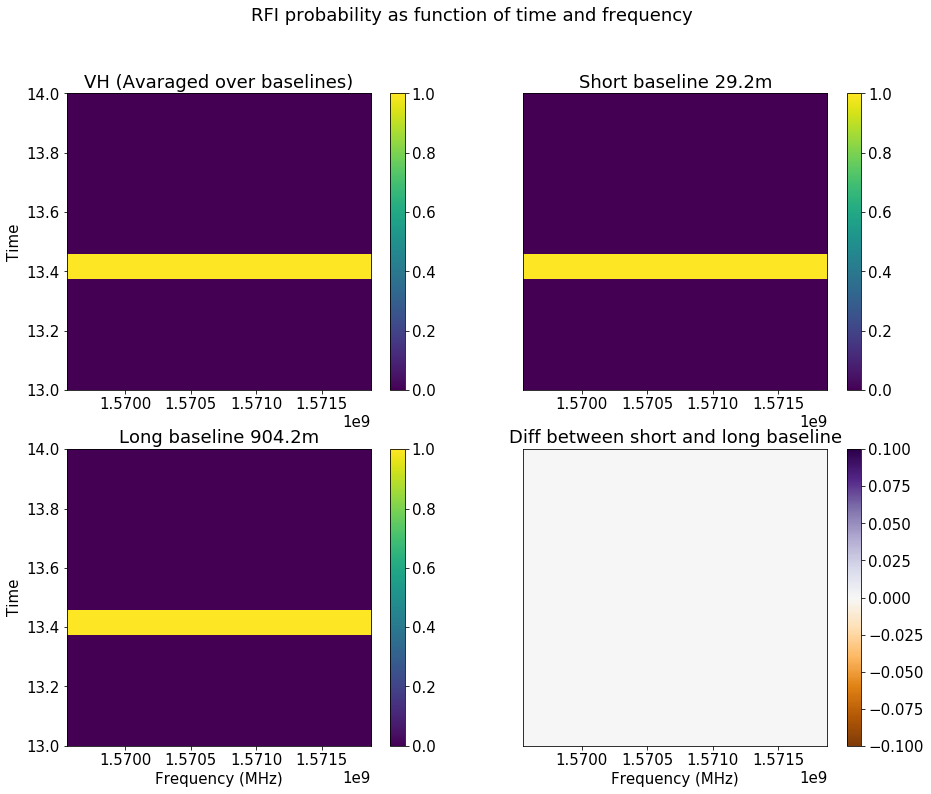

In [379]:

plt.suptitle('RFI probability as function of time and frequency')
plt.subplot(221)
plt.imshow(probG, cmap=None, interpolation='nearest',aspect='auto',
           extent=[freqs_used[0],freqs_used[-1],min(hours),max(hours)])
plt.title(my_pol+' (Avaraged over baselines)')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(222)
plt.title('Short baseline '+str(round(length[np.argmin(length)],1))+'m')
plt.imshow(prob_bl[0] , cmap=None, interpolation='nearest',aspect='auto',
           extent=[freqs_used[0],freqs_used[-1],min(hours),max(hours)])
plt.yticks([])
plt.colorbar()

plt.subplot(223)
plt.title('Long baseline '+str(round(length[np.argmax(length)],1))+'m')
plt.imshow(prob_bl[1], cmap=None, interpolation='nearest',aspect='auto',
           extent=[freqs_used[0],freqs_used[-1],min(hours),max(hours)])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time')
plt.colorbar()

plt.subplot(224)
plt.title('Diff between short and long baseline')
plt.imshow(abs(prob_bl[0].astype(np.float32)-prob_bl[1].astype(np.float32)), cmap='PuOr', 
           interpolation='nearest',aspect='auto',
           extent=[freqs_used[0],freqs_used[-1],min(hours),max(hours)])

plt.yticks([])
plt.xlabel('Frequency (MHz)')
plt.colorbar()

plt.show()

In [380]:
def flags_per_B(big,idx,Gflags):
    b = np.sum(big.astype(float)[:,:,idx], axis=(0,1))
    f = np.array(b)
    deno = Gflags.shape[0]*Gflags.shape[1]
    f = f/deno
    f=f*100
    return f
    

In [381]:
Gflags.shape

(448, 90, 120)

In [382]:
f = flags_per_B(prob_bl[2],idx,Gflags)

In [383]:
import scipy

from scipy.optimize import curve_fit

bllen = np.array(length)[idx]
percent = f

poly = np.polyfit(bllen,f,3)

def logconst(xval, a, c):
    return a*np.log(xval) + c

fit, _ = curve_fit(logconst,bllen,percent)
print fit


[-6.25332771e-09  1.00000000e+02]


In [384]:
print('Min and max baseline length %.3fm %.3fm') %(min(length),max(length))

Min and max baseline length 29.249m 904.239m


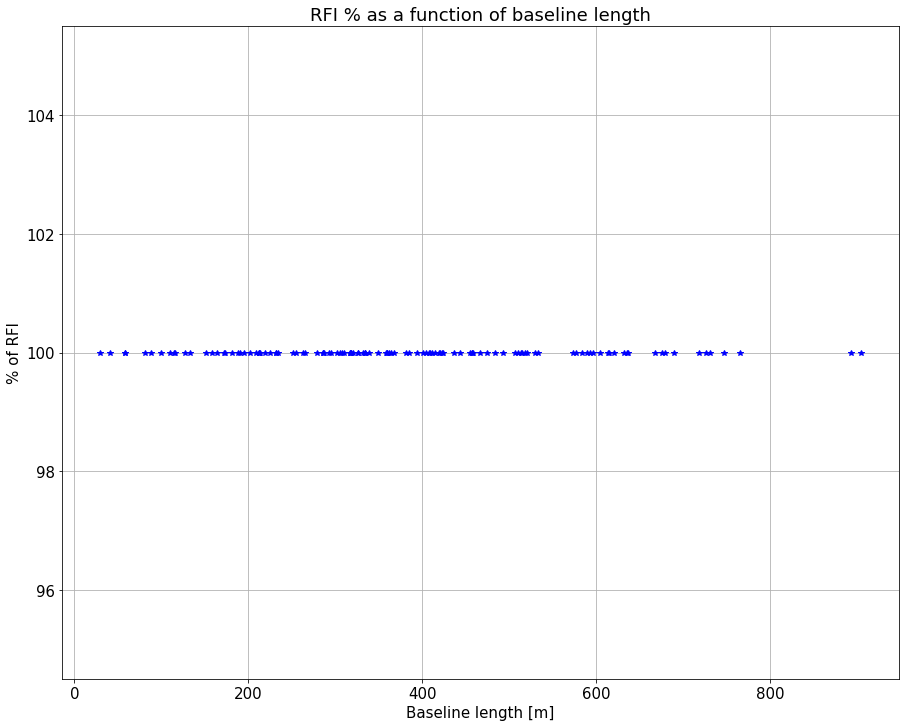

In [385]:
plt.figure(figsize=(15,12))
plt.plot((np.array(length))[idx],f,'b*')
xs=np.linspace(0.,8000.,5000)
#plt.plot(xs,np.poly1d(poly)(xs))
#plt.plot(xs,logconst(xs, *fit))
plt.ylabel('% of RFI')
plt.title('RFI % as a function of baseline length')
plt.xlabel('Baseline length [m]')
#plt.xlim(0,5)
plt.grid()
plt.show()

In [386]:
cut_off = float(raw_input('Enter %RFI outlier cut_off '))

Enter %RFI outlier cut_off 101


In [387]:
outlier_list = list((np.array(baseline)[idx][np.where(f>cut_off)]).flatten())
if len(outlier_list) > 1:
    print('Outlier antenna is '), (max(set(outlier_list), key = outlier_list.count))


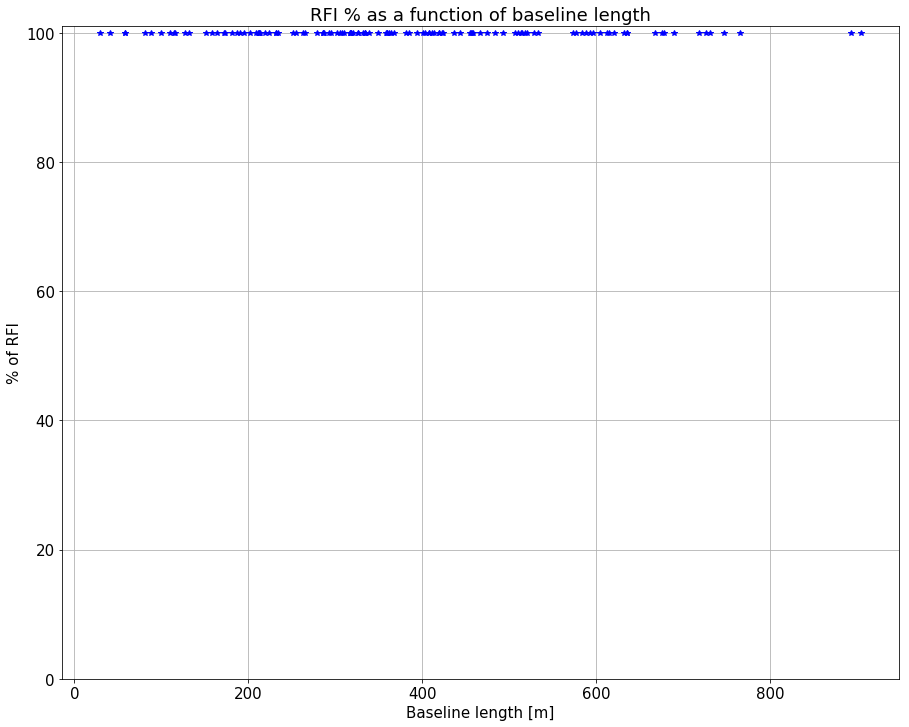

In [388]:
plt.figure(figsize=(15,12))
plt.plot((np.array(length))[idx],f,'b*')
xs=np.linspace(0.,8000.,5000)
#plt.plot(xs,np.poly1d(poly)(xs))
#plt.plot(xs,logconst(xs, *fit))
plt.ylabel('% of RFI')
plt.title('RFI % as a function of baseline length')
plt.xlabel('Baseline length [m]')
plt.ylim(0,cut_off)
plt.grid()
plt.show()

In [389]:
import scipy

from scipy.optimize import curve_fit

bllen = np.array(length)[idx]
percent = f

np.polyfit(bllen,f,2)


array([ 5.71519286e-19, -1.71137913e-16,  1.00000000e+02])

In [390]:
def flags_per_f(big,idx,Gflags):
    b = np.sum(big.astype(float)[:,:,idx], axis=(0,2))
    f = np.array(b)
    deno = Gflags.shape[0]*Gflags.shape[2]
    f = f/deno
    f=f*100
    return f
    

In [391]:
c = flags_per_f(prob_bl[2],idx,Gflags)

In [392]:
print '========='
print 'RFI stats'
print '========='
print 'Min %.1f\nMax %.1f\nMean %.1f\nMedian %.1f\n '%(c.min(),c.max(),c.mean(), np.median(c))

RFI stats
Min 100.0
Max 100.0
Mean 100.0
Median 100.0
 


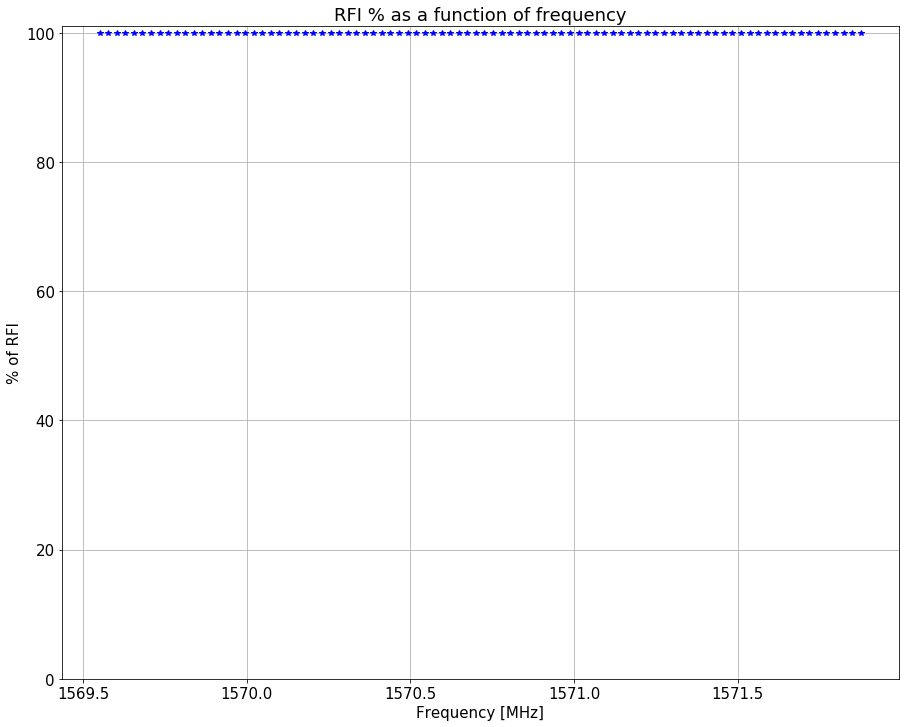

In [393]:
plt.plot(freqs_used/1.0e6,c,'b*')
plt.ylabel('% of RFI')
plt.title('RFI % as a function of frequency')
plt.xlabel('Frequency [MHz]')
plt.ylim(0,cut_off)
plt.grid()
plt.show()

Text(0.5,0,'% of RFI')

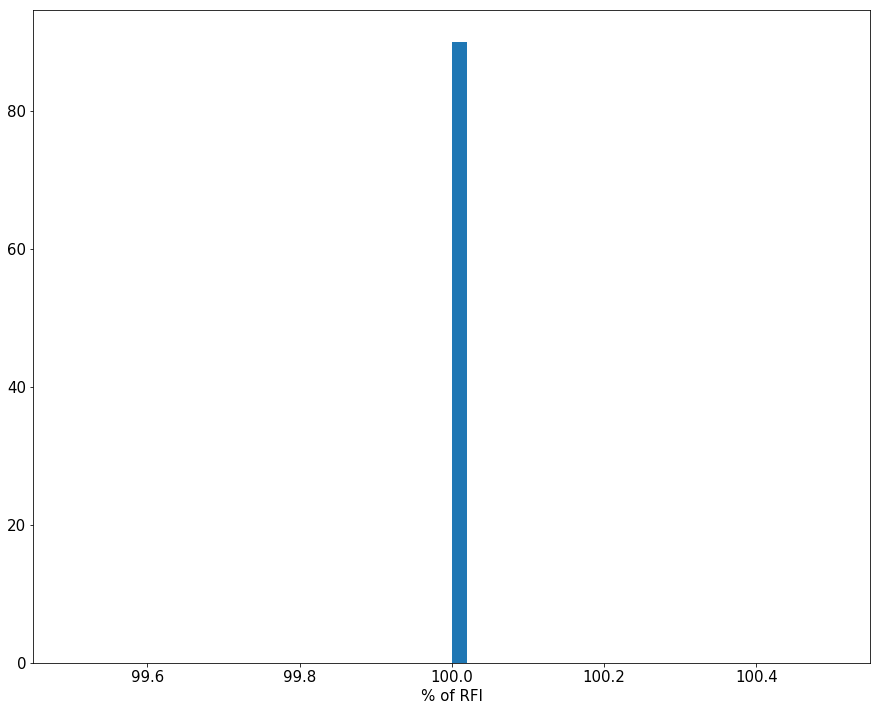

In [394]:
plt.hist(c,50);
plt.xlabel('% of RFI')